# Experimental Design
***
## Optimising underlayers

Import the necessary libraries

In [5]:
import copy
%matplotlib inline

from hogben.models.samples import Sample, MagneticLayer
import numpy as np
from hogben.optimise import Optimiser
from hogben.utils import Fisher
from refnx.reflect import SLD

import matplotlib.pyplot as plt
from hogben.simulate import simulate

def refnx_sample():
    """Define a bilayer sample, and return the associated refnx model"""
    # Define sample
    air = SLD(0, name='Air')
    layer2 = SLD(6, name='Layer 2')(thick=104, rough=8)
    underlayer = MagneticLayer(SL=0.1, thick=20, rough=5, mag=4.0, density=7)
    substrate = SLD(2, name='Substrate')(thick=0, rough=5)
    
    layer2.thick.bounds = (10, 30)
    layer2.rough.bounds = (4, 10)

    params = [
        layer2.thick,
        layer2.rough,
    ]
    for param in params:
        param.vary = True

    sample = air  | layer2 | underlayer | substrate
    return sample

model = refnx_sample()
sample = Sample(model)


Create a new sample:

In [6]:
def get_eigenval_sld(sample, angle_times, sld_n, sld_m):
    sld_spins = [sld_n + sld_m, sld_n - sld_m]
    qs, counts, models = [], [], []
    for sld in sld_spins:
        for layer in sample.structure:
            if hasattr(layer, 'underlayer') and layer.underlayer:
                layer.sld.real.value = sld
        model, data = simulate(
            sample.structure, angle_times, scale=sample.scale,
            bkg=sample.bkg,
            dq=sample.dq
        )
        qs.append(data[:, 0])
        counts.append(data[:, 3])
        models.append(model)
    xi = sample.get_varying_parameters()
    fisher = Fisher(qs, xi, counts, models)

    return fisher.min_eigenval

Optimise



In [7]:
def get_eigenval(sample, angle_times):
    qs, counts, models = [], [], []

    for structure in sample.get_structures():          
        model, data = simulate(
            structure,
            angle_times,
            scale=sample.scale,
            bkg=sample.bkg,
            dq=sample.dq
        )
        qs.append(data[:, 0])
        counts.append(data[:, 3])
        models.append(model)
    xi = sample.get_varying_parameters()
    fisher = Fisher(qs, xi, counts, models)
    return fisher.min_eigenval
angle_times = [(0.7, 100, 10),
               (2.3, 100, 40),]
print(get_eigenval(sample, angle_times))

0.719191409496182


In [8]:
nsld_bounds = (-1, 5)
msld_bounds = (0, 3)
thick_bounds = (20,200)
angle_times = [(0.7, 100, 10),
               (2.3, 100, 40),
               ]
sample = Sample(model, bkg=1e-6)

In [9]:
print(get_eigenval(sample, angle_times))


0.7450382877567612


In [10]:
new_structure = copy.deepcopy(sample.structure)
structures = []

for layer in new_structure:
    if hasattr(layer, 'underlayer') and layer.underlayer:
        spin_up_structure = copy.deepcopy(sample.structure)
        spin_up_structure[new_structure.index(layer)] = layer.spin_up
        structures.append(spin_up_structure)

        spin_down_structure = copy.deepcopy(sample.structure)
        spin_down_structure[new_structure.index(layer)] = layer.spin_down
        structures.append(spin_down_structure)


In [11]:

conditions = {"nsld_bounds": nsld_bounds,
              "msld_bounds": msld_bounds,
              "thick_bounds": (10, 150),
              "sld_bounds": (0, 10),
              "angle_times": angle_times,
              }
optimiser = Optimiser(sample)

sld_n, sld_m, val = \
    optimiser.optimise_sld(sample, conditions,
                           verbose=False)

In [12]:
sld_n_range = nsld_bounds[1] - nsld_bounds[0]
sld_m_range = msld_bounds[1] - msld_bounds[0]

eigenval = []
sld_n_array = []
sld_m_array = []

res = 25 # Set how fine the mesh should be

for i in range(res):
    sld_n = (sld_n_range/res)*(i+1) + nsld_bounds[0]
    sld_n_array.append([])
    sld_m_array.append([])
    print(f"{i+1}/{res}")
    for j in range(res):
        sld_m = (sld_m_range/res)*(j+1) + msld_bounds[0]
        sld_spins = [sld_n + sld_m, sld_n - sld_m]
        min_eigenval = get_eigenval_sld(sample, angle_times, sld_n, sld_m)
        eigenval.append(min_eigenval)
        sld_n_array[i].append(sld_n)
        sld_m_array[i].append(sld_m)

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


In [13]:

# Split the original array into chunks of 10 elements
def get_eigenvals(eigenval, res, log=False):
    chunks = []
    for i in range(0, len(eigenval), res):
        list_2 = eigenval[i:i+res]
        new_list = []
        for item in list_2:
            if log:
                item += 0.001
                item = np.log(item)
            new_list.append(item)
        chunk = new_list

        chunks.append(chunk)
    return np.asarray(chunks)

<Figure size 7200x5400 with 0 Axes>

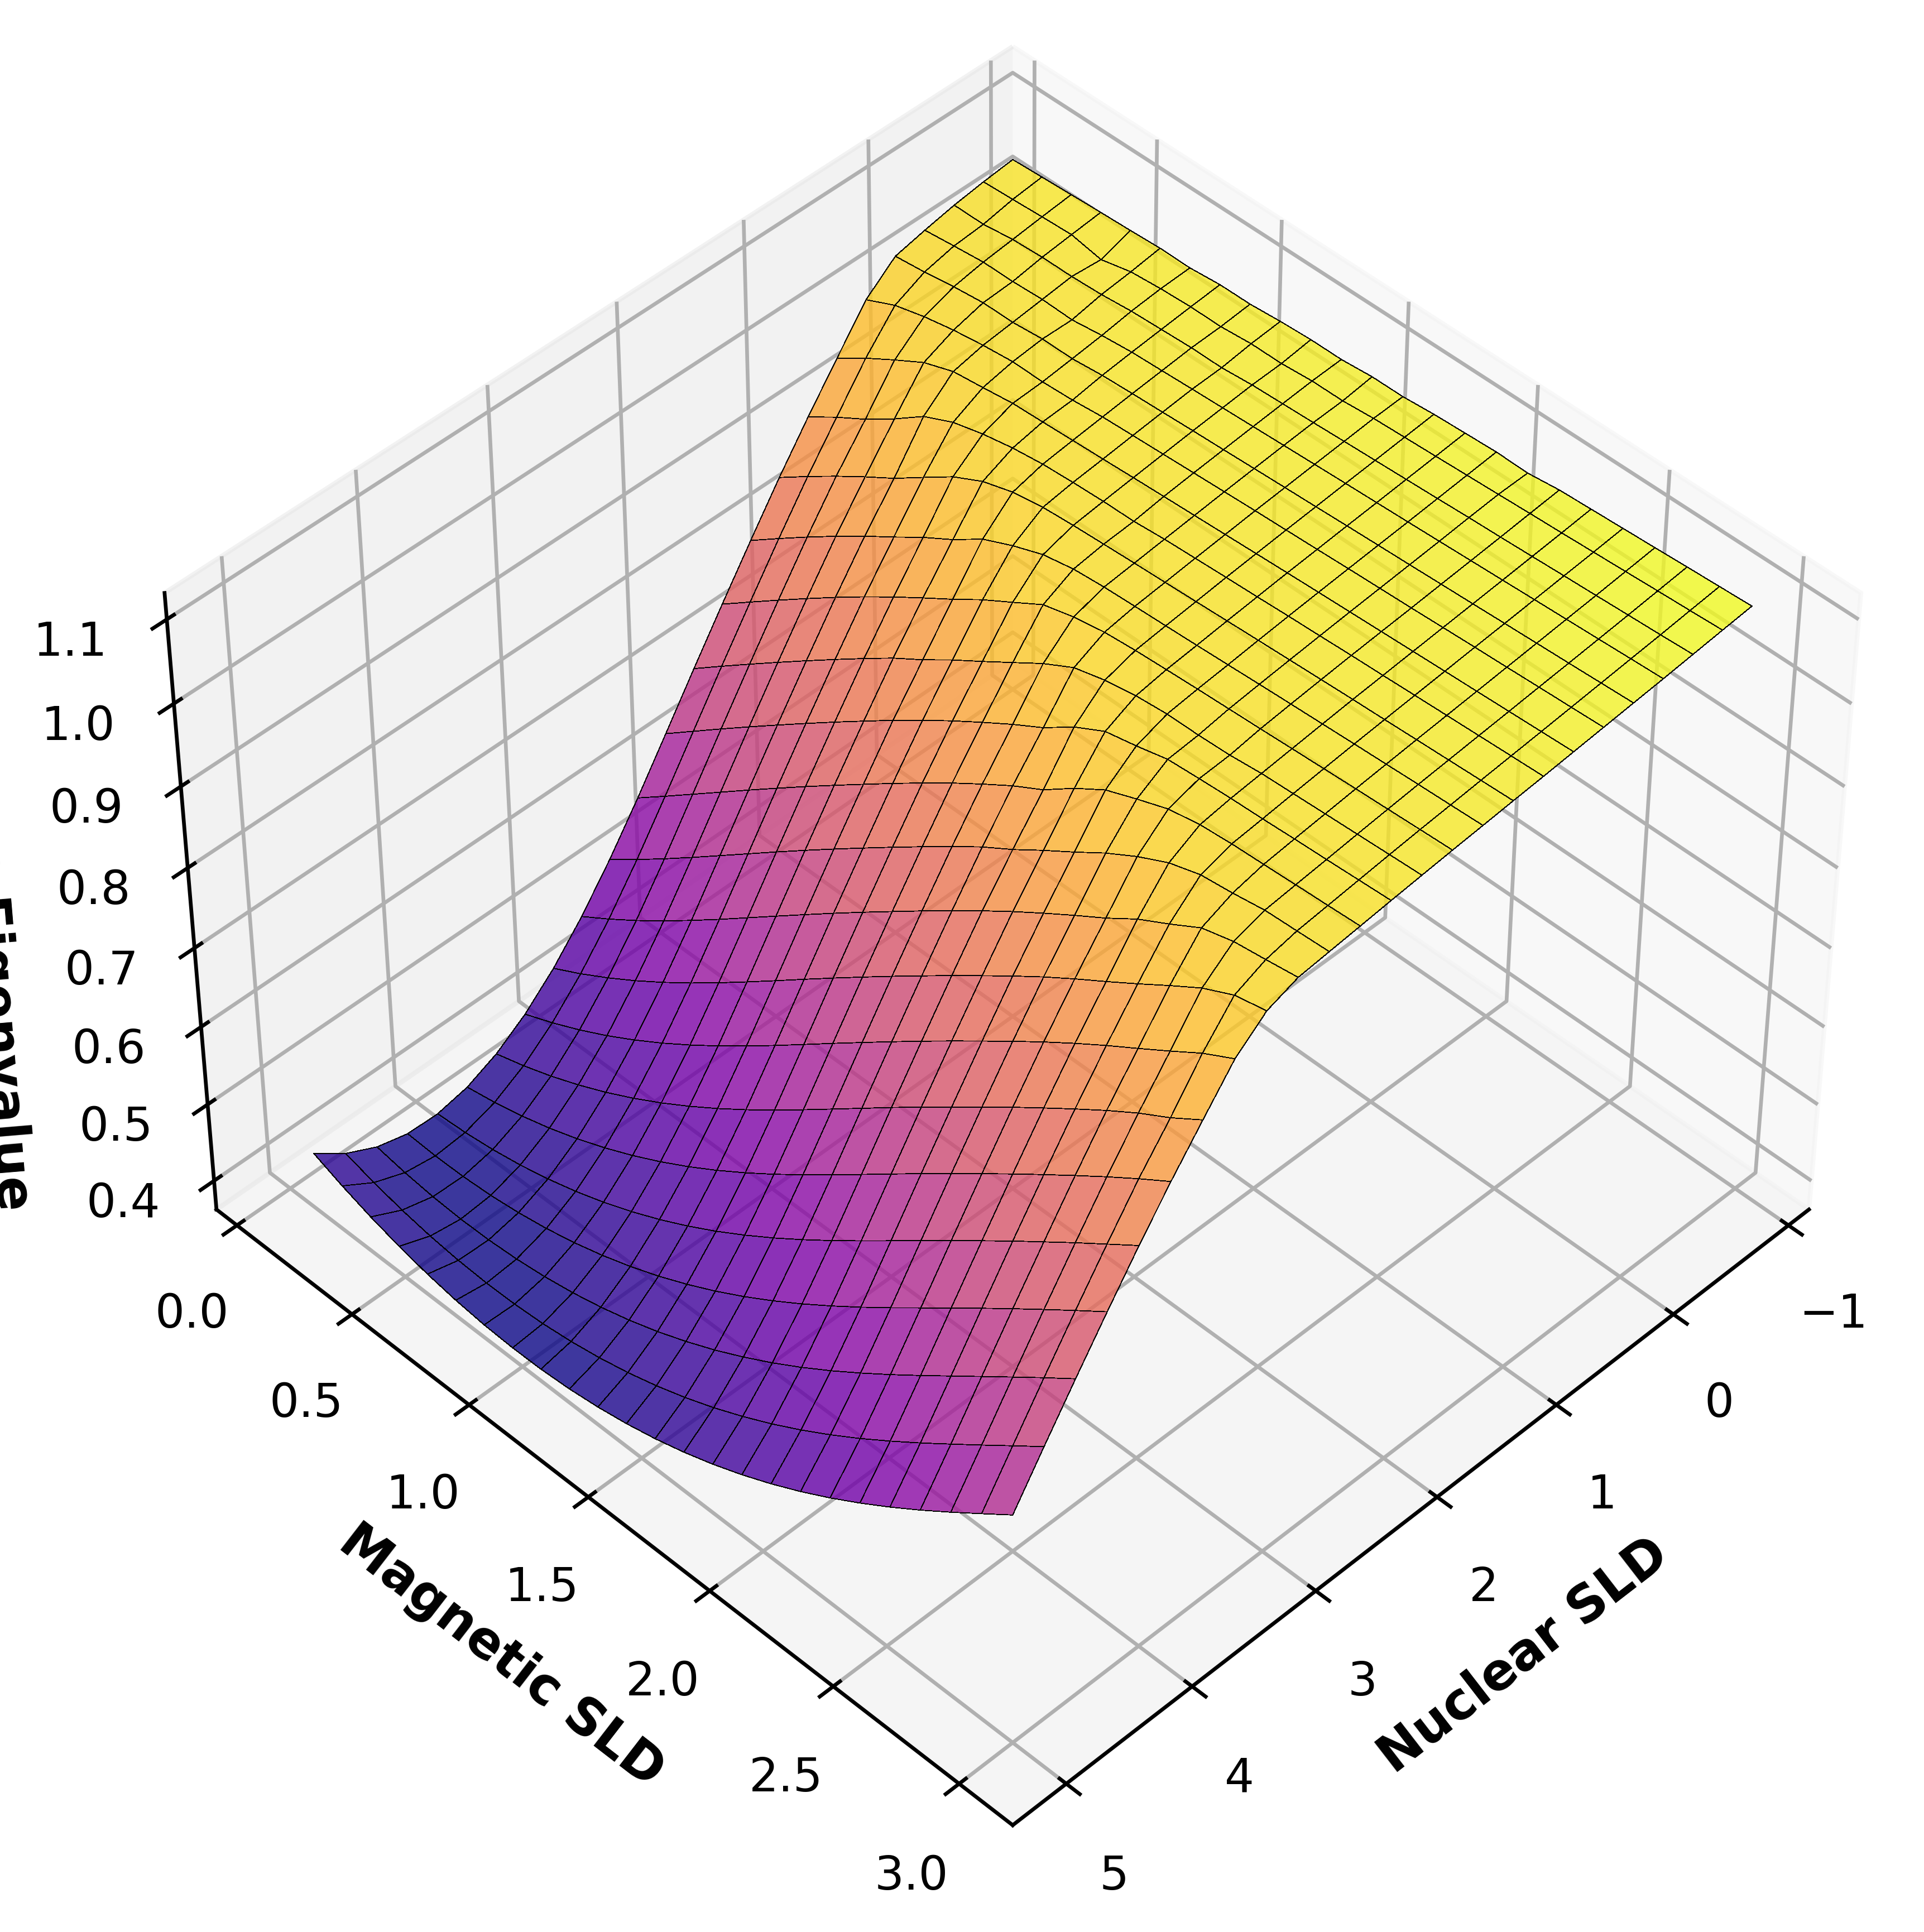

In [14]:
chunks = get_eigenvals(eigenval, res, log=False)


fig = plt.figure(figsize=[12, 9])
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_label = 'Nuclear SLD'
y_label = 'Magnetic SLD'
z_label = 'Minimum Eigenvalue'
ax.set_xlabel(x_label, fontsize=11, weight='bold')
ax.set_ylabel(y_label, fontsize=11, weight='bold')
ax.set_zlabel(z_label, fontsize=11, weight='bold')

surface = ax.plot_surface(sld_n_array, sld_m_array, chunks,
                       linewidth=0.1, antialiased=False, cmap="plasma",
                          edgecolors='black', alpha=0.8,
                          )

#surface = ax.plot_wireframe(sld_n_array, sld_m_array, chunks)
ax.view_init(45, 45)


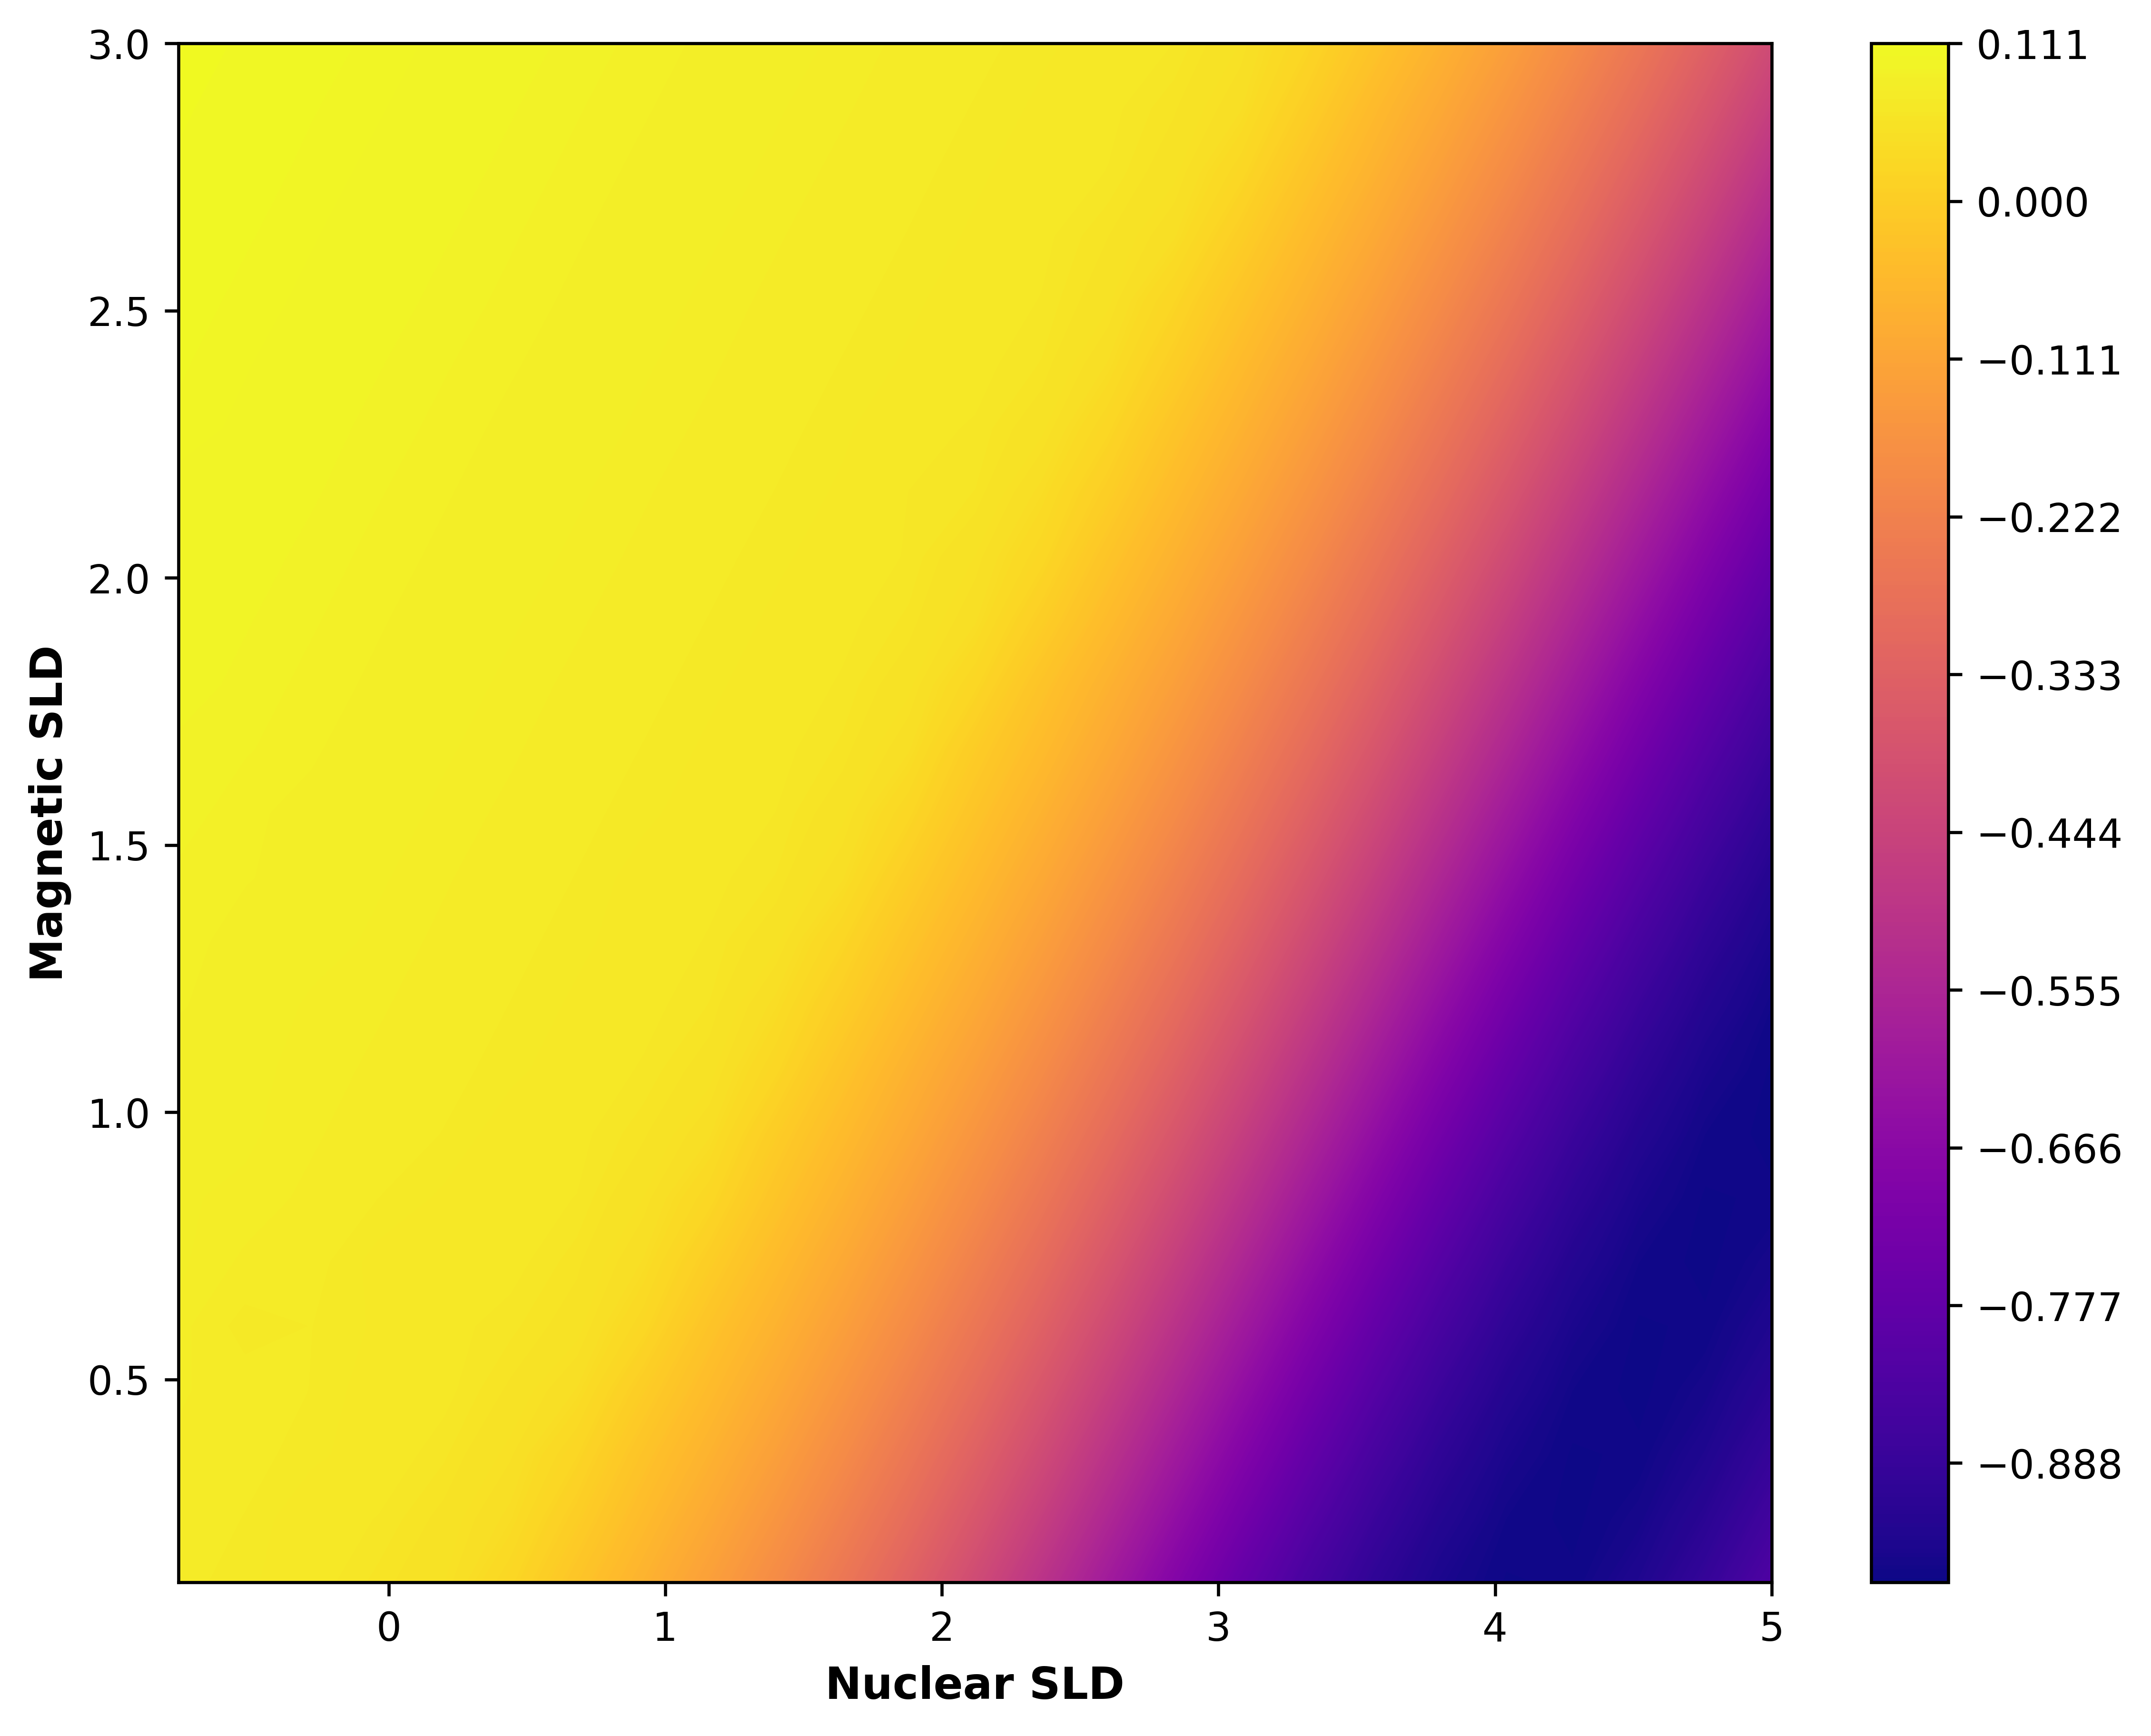

In [15]:
fig, ax = plt.subplots()
chunks = get_eigenvals(eigenval, res, log=True)

CS = ax.contourf(sld_n_array, sld_m_array, chunks, 400, cmap="plasma")
ax.set_xlabel(x_label, fontsize=11, weight='bold')
ax.set_ylabel(y_label, fontsize=11, weight='bold')
CB = fig.colorbar(CS)

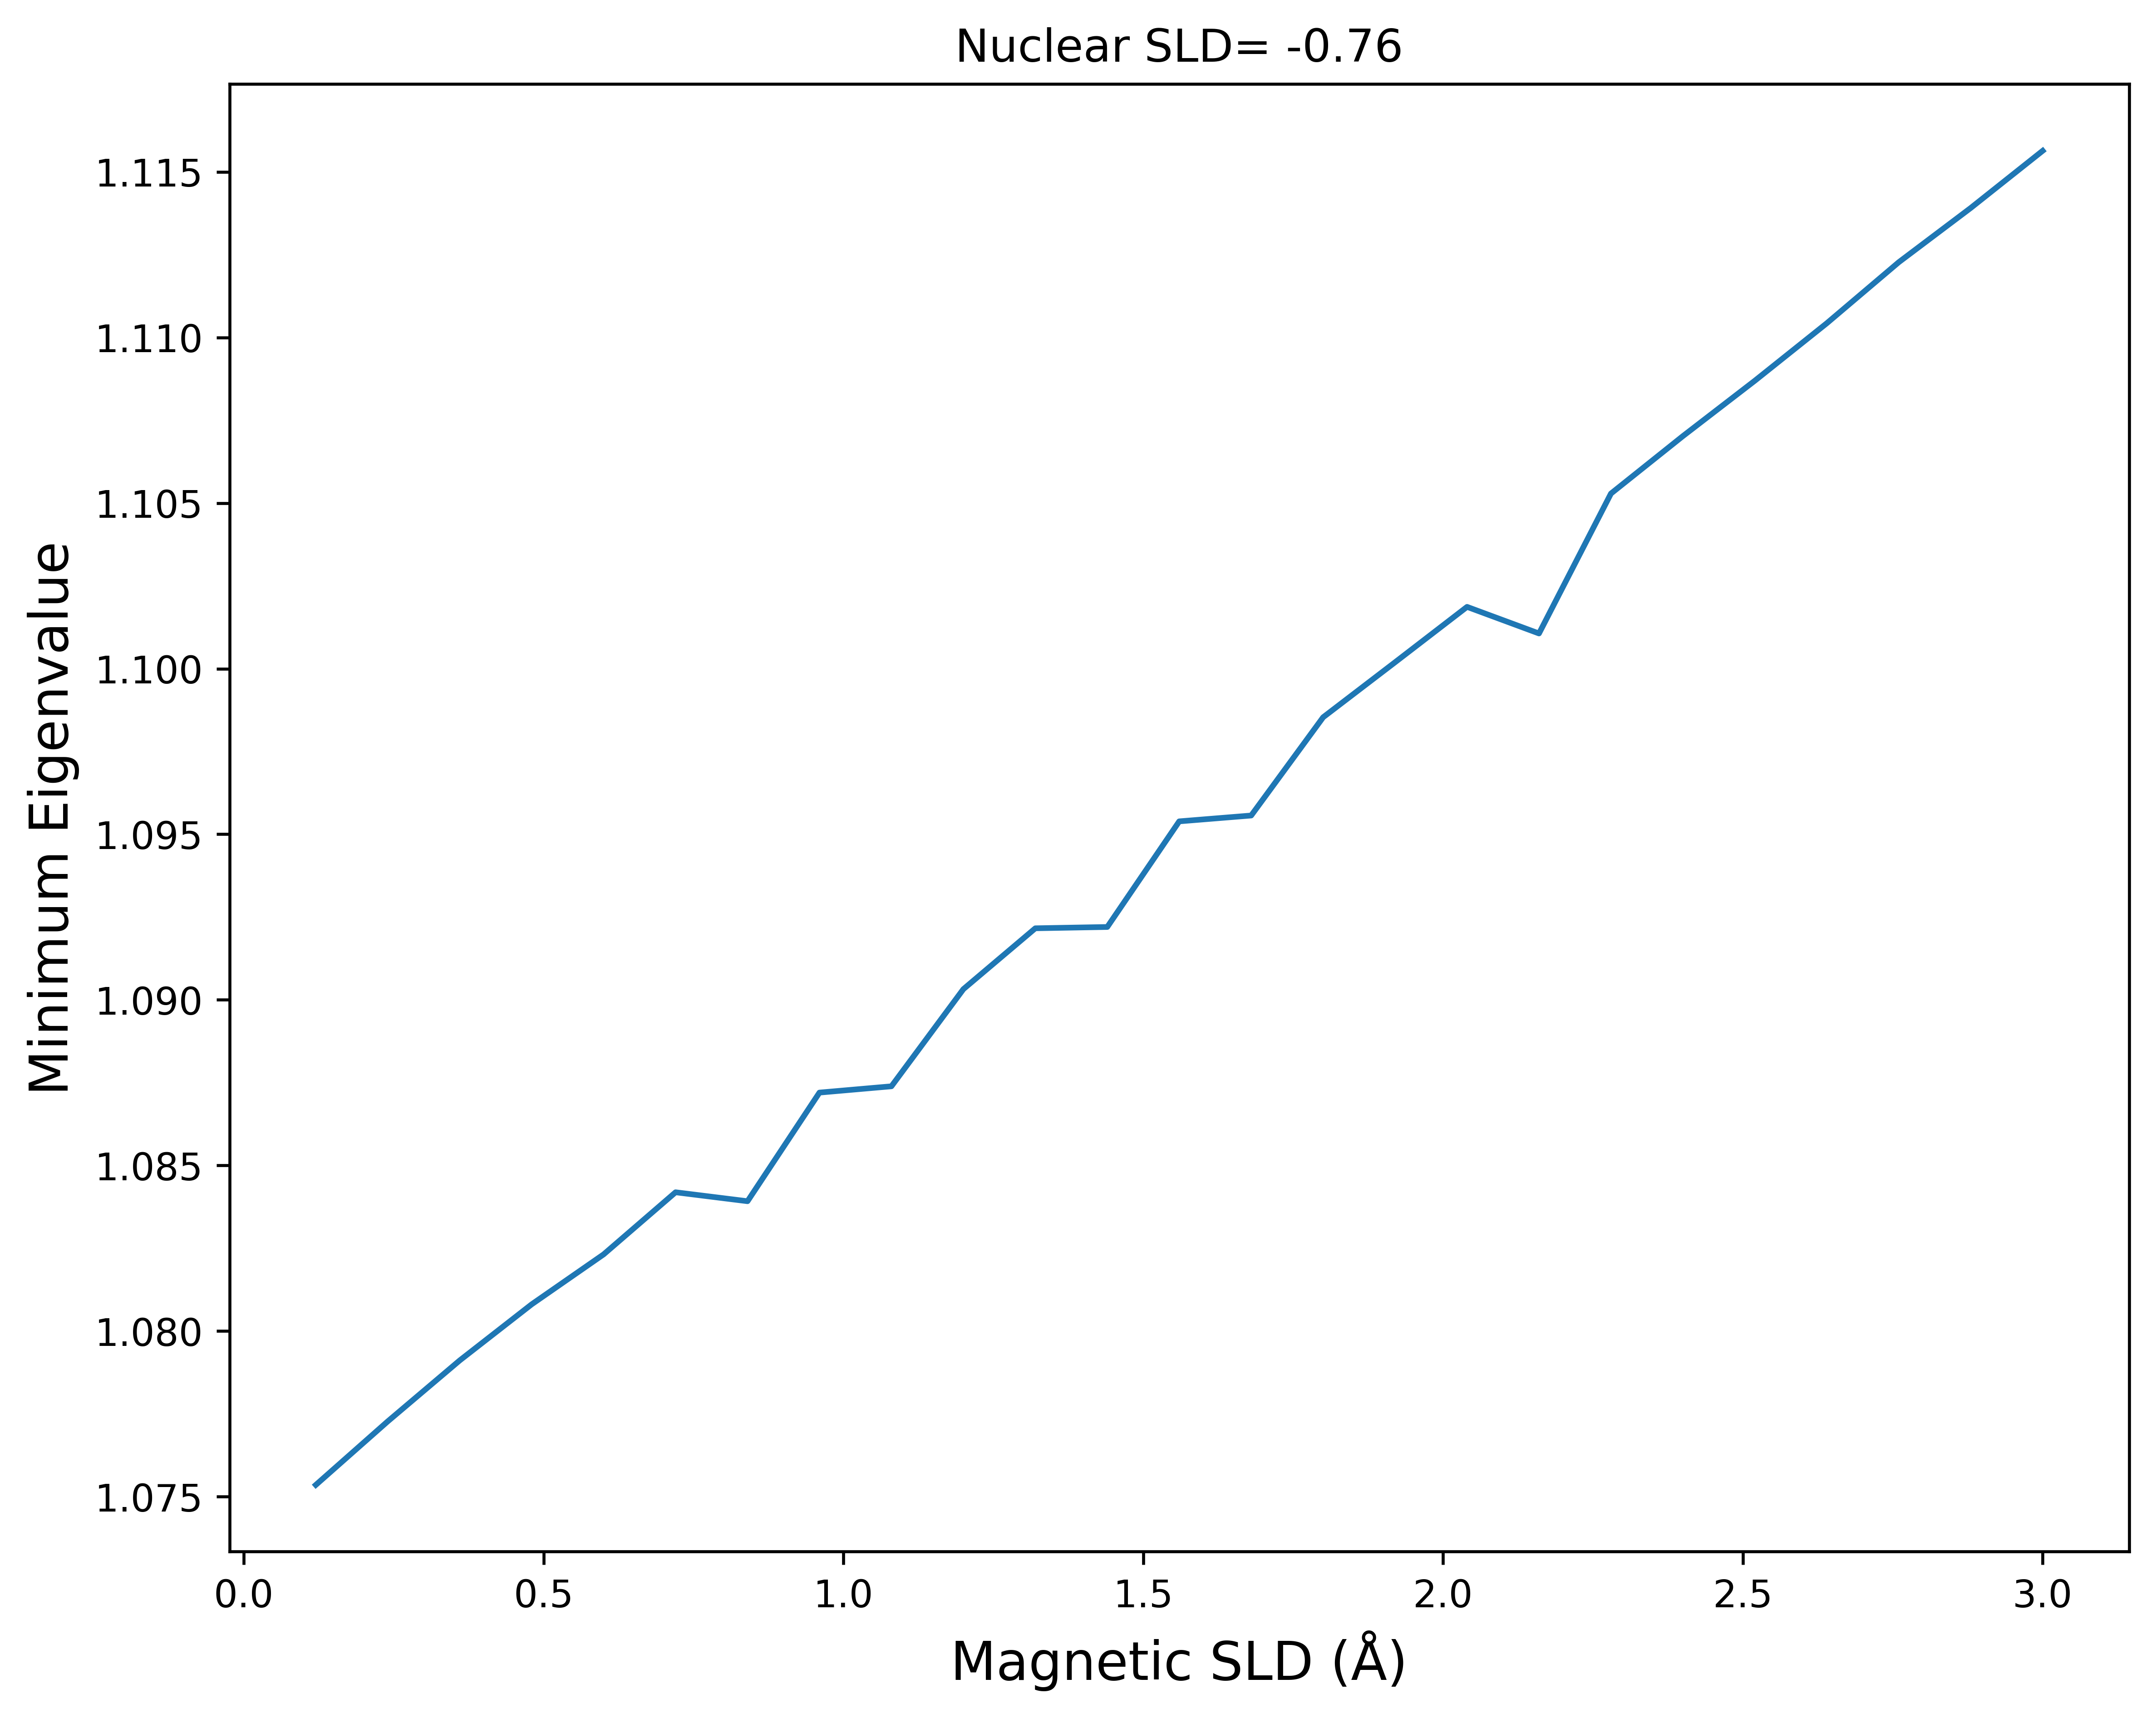

In [16]:
chunks = get_eigenvals(eigenval, res, log=False)

max_a = 0
i = 0
for a in chunks:
    if max(a) > max_a:
        max_a = max(a)
        j = i
    i+= 1
fig, ax = plt.subplots()
j = 0
ax.set_xlabel('Magnetic SLD (Å)', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue', fontsize = 14)
ax.set_title(f"Nuclear SLD= {sld_n_array[j][-1]}")
ax.plot(sld_m_array[j], chunks[j])

In [17]:
chunks = get_eigenvals(eigenval, res, log=False)

chunks_n = [[] for _ in range(res)]
for chunk in chunks:
    for index2, value in enumerate(chunk):
        chunks_n[index2].append(value)

j = 0
max_a = 0
i = 0

for a in chunks_n:
    if max(a) > max_a:
        max_a = max(a)
        j = i
    i+= 1

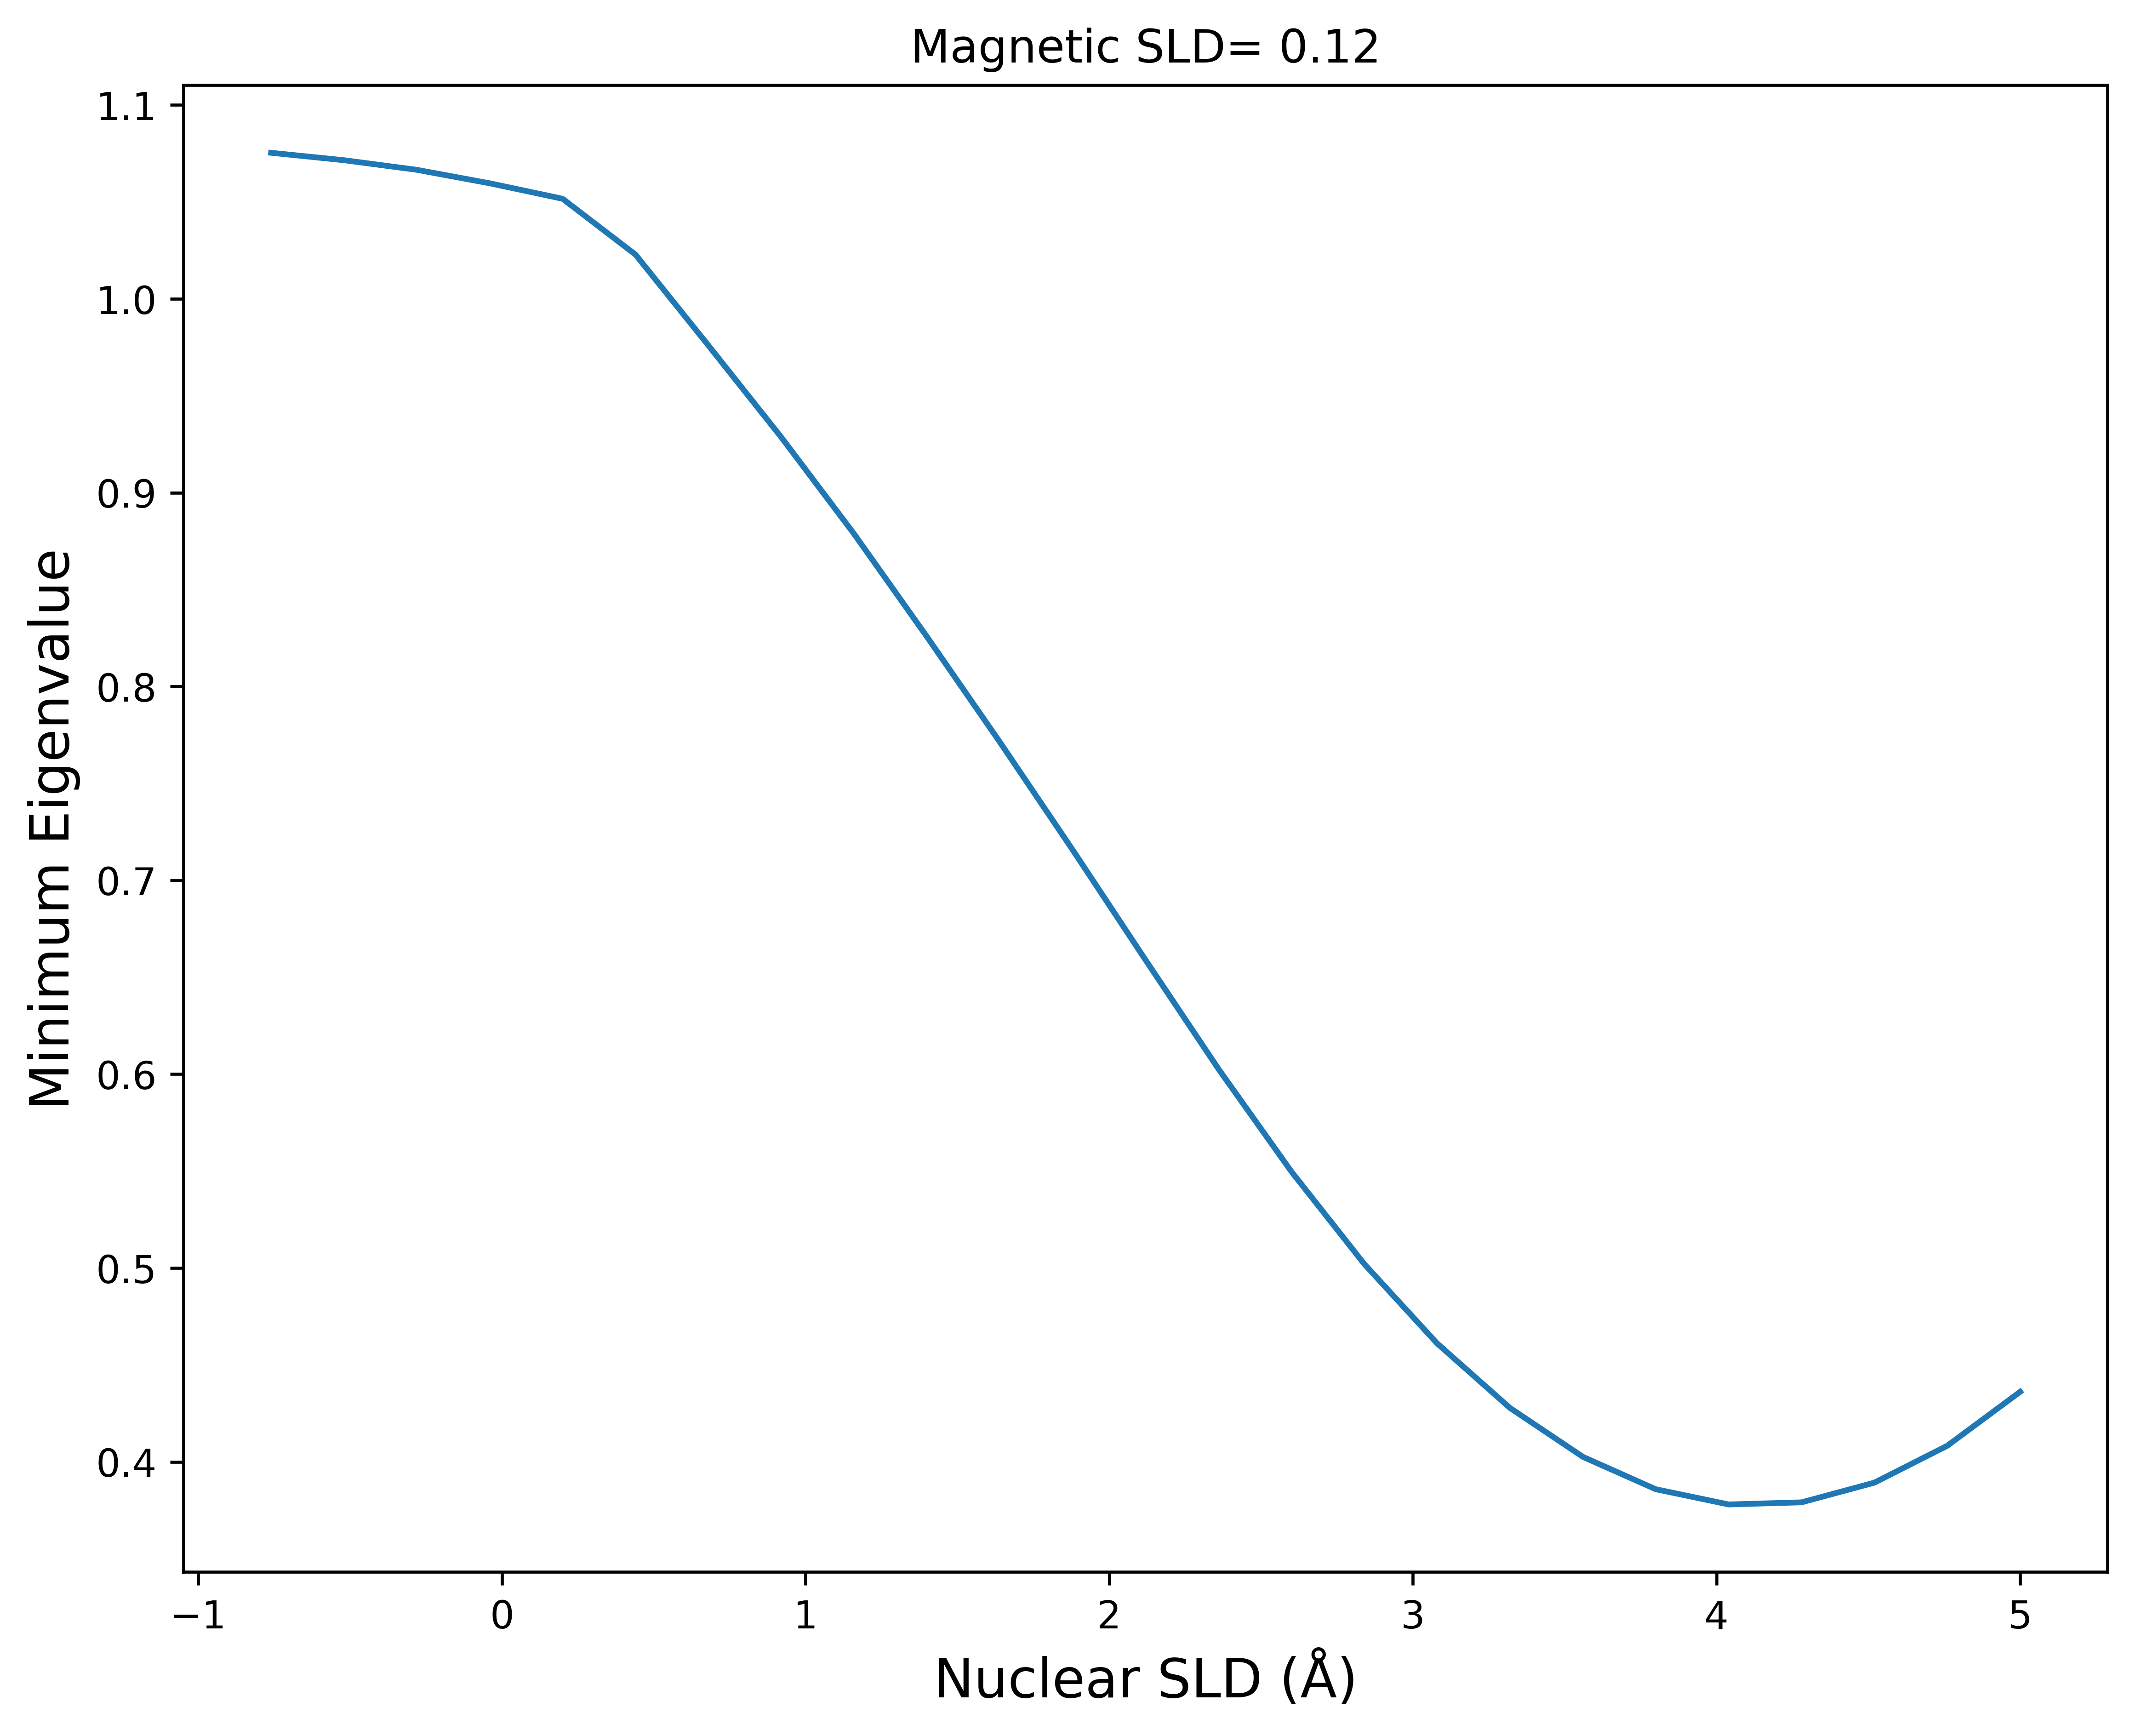

In [18]:
fig, ax = plt.subplots()

j = 0
ax.set_xlabel('Nuclear SLD (Å)', fontsize = 14)
ax.set_ylabel('Minimum Eigenvalue', fontsize = 14)
ax.set_title(f"Magnetic SLD= {sld_m_array[j][j]}")


sld_n_list = []
for array in sld_n_array:
    sld_n_list.append(array[0])
ax.plot(sld_n_list, chunks_n[j])

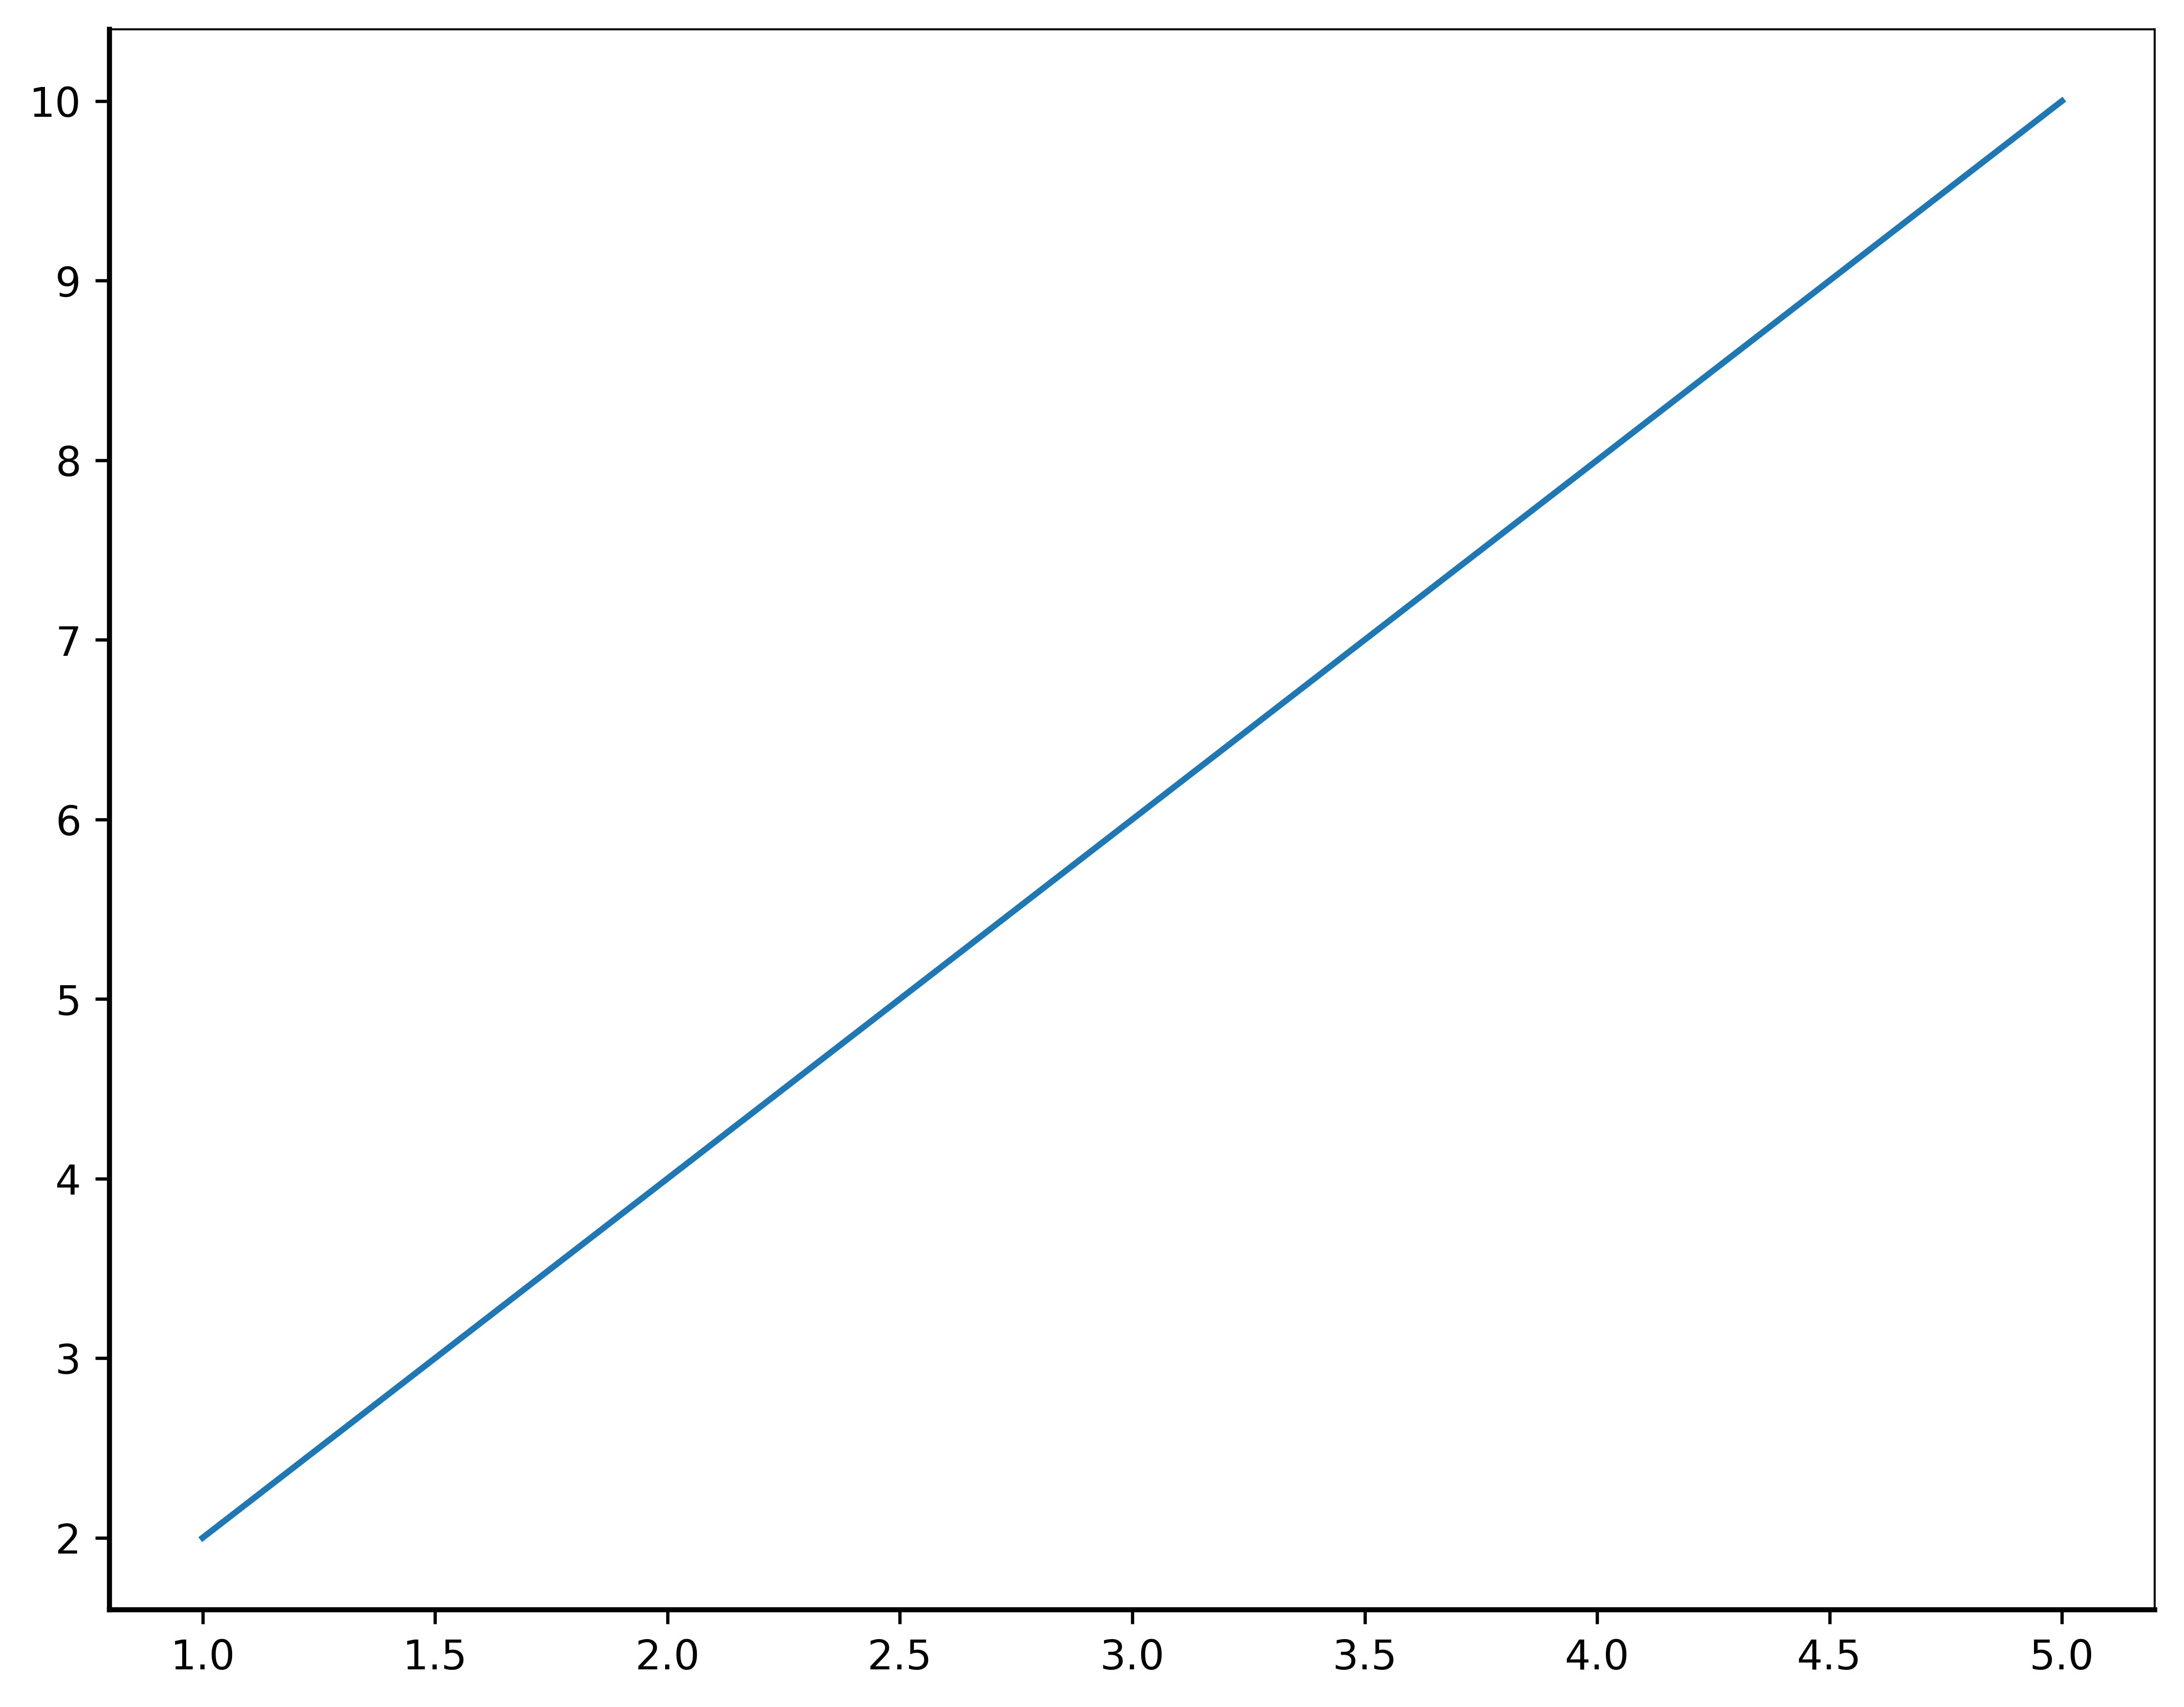

In [19]:
import matplotlib.pyplot as plt

# Create some example data
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Customize the appearance of the spines
ax.spines['left'].set_linewidth(1.25)    # Set left y-axis spine to be thick
ax.spines['right'].set_linewidth(0.5)  # Set right y-axis spine to be thin
ax.spines['bottom'].set_linewidth(1.25) # Set bottom x-axis spine to be thin
ax.spines['top'].set_linewidth(0.5)    # Set top x-axis spine to be thin

# Show the plot
plt.show()